# Collaboration and Competition: Multi-Agent Actor-Critic Approach



#### Start the Environment

This notebook serves to try out Multi-Agent Actor-Critic for mixed cooperative-competitive environments., using Udacity's Tennis environment, which strongly resembles the Unity Tennis environment.

Necessary packages have to be imported first.

Before proceeding, please make sure that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and that the Reacher Environment is placed properly in your project folder. In case of doubts, refer to [README](TODO).

In [3]:
from unityagents import UnityEnvironment
import numpy as np
import os

import torch
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

import time
plt.ion()

from multiagent import MultiAgentWrapper

In [4]:
os.makedirs("./weights", exist_ok = True) 

In [5]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

#### Examine the State and Action Spaces

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


#### Train the agents

In [18]:
def maddpg(n_episodes=100000, max_t=10000, window_size=100, score_threshold=0.5, print_every=50, agent=None):
    """ TODO
    
    Params:
    TODO
    """
    assert agent, "Agent has not been initialized properly."
    scores = []
    scores_deque = deque(maxlen=window_size)
    
    for i_episode in range(1, n_episodes+1): 
        
        rewards = []
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations 

        for step in range(max_t):
            # select action for each agent based on its own state
            action = agent.act(state)
            env_info = env.step(action)[brain_name]     
            next_state = env_info.vector_observations   
            rewards_vec = env_info.rewards                   
            done = env_info.local_done
            
            # update and train agent
            agent.step(state, action, rewards_vec, next_state, done)
            state = next_state
            rewards.append(rewards_vec)

            if np.any(done):
                break
                
        # episode score is the maximum of individually collected rewards of agents
        episode_reward = np.max(np.sum(np.array(rewards),axis=0))
        
        # use current episode score to calculate running average (of window_size) and to accumulate for all scores history
        scores_deque.append(episode_reward)
        scores.append(episode_reward)

        # calculate current running average score
        current_avg_score = np.mean(scores_deque)
        
        if i_episode % print_every  == 0:
            print(f"Episode:{i_episode}, Current Average Score:{current_avg_score:.2f}")
        
        # break if environment is solved, according to the requirements
        if current_avg_score > score_threshold:
            print(f"Environment solved, the agents scored on average above the required threshold of {score_threshold:.2f}")
            print(f"Episode:{i_episode}, Current Average Score:{current_avg_score:.2f}")
            
            for i, agent in enumerate(agent.agents):
                torch.save(agent.actor_local.state_dict(),  f"checkpoint_actor_agent_{i}.pth")
                torch.save(agent.critic_local.state_dict(), f"checkpoint_critic_agent_{i}.pth")
            break
            
    return scores

In [19]:
seed = 42 
agent = MultiAgentWrapper(seed=2, noise_start=0.5, gamma=1, state_size=state_size)

In [20]:
scores = maddpg(n_episodes=10000, max_t=10000, agent=agent)

Episode:50, Current Average Score:0.00
Episode:100, Current Average Score:0.00
Episode:150, Current Average Score:0.00
Episode:200, Current Average Score:0.00
Episode:250, Current Average Score:0.00
Episode:300, Current Average Score:0.01
Episode:350, Current Average Score:0.03
Episode:400, Current Average Score:0.03
Episode:450, Current Average Score:0.01
Episode:500, Current Average Score:0.01
Episode:550, Current Average Score:0.02
Episode:600, Current Average Score:0.02
Episode:650, Current Average Score:0.02
Episode:700, Current Average Score:0.03
Episode:750, Current Average Score:0.04
Episode:800, Current Average Score:0.05
Episode:850, Current Average Score:0.07
Episode:900, Current Average Score:0.07
Episode:950, Current Average Score:0.08
Episode:1000, Current Average Score:0.09
Episode:1050, Current Average Score:0.09
Episode:1100, Current Average Score:0.09
Episode:1150, Current Average Score:0.09
Episode:1200, Current Average Score:0.10
Episode:1250, Current Average Score:

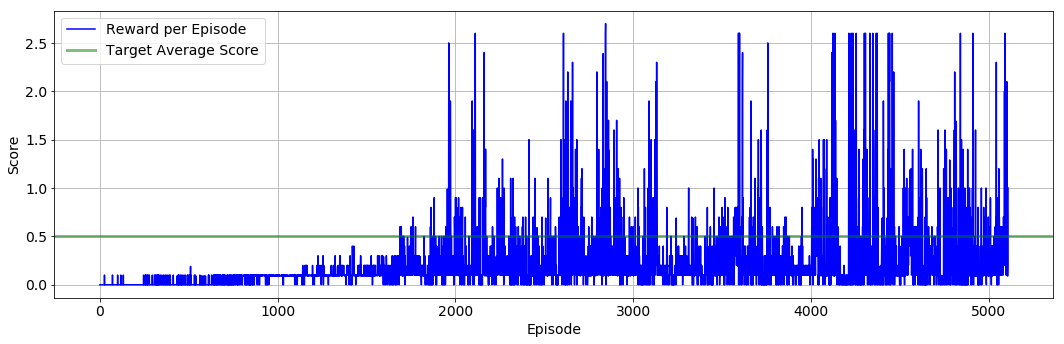

In [26]:
fig, ax = plt.subplots(1, 1, figsize=[15, 5])

ax.plot(np.arange(1, len(scores)+1), scores,'b', label='Scores per episode')

ax.set_xlabel("Episode")
ax.set_ylabel("Score")
ax.grid(which="major")

ax.axhline(0.5, c="green", linewidth=3, alpha=0.5)
ax.legend(["Reward per Episode", "Target Average Score"])

fig.tight_layout()
fig.savefig("plot.jpg")

In [28]:
env.close()